# Diseño de mini-red neuronal para predicción de matrículas

**Alumno:** VASQUEZ RAMOS, Jose Manuel

**Fecha:** 20/05/2025

___

## Contexto académico & objetivo

Maximiza exactitud en clasificación (Alta-Media-Baja) evolutivamente variando nº capas (1-3), neuronas y tasa de aprendizaje.

## Indicaciones clave

1) Genotipo mixto (enteros + float).
2) Usa mutación e hill climbing local (pequeños ajustes).
3) Limita epochs = 20.
4) Muestra arquitectura final y accuracy.


## Librerías

In [1]:
import numpy as np
import pandas as pd
import random
from deap import base, creator, tools, algorithms
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

## Semilla para reproducibilidad

In [2]:
random.seed(42)
np.random.seed(42)

## Dataset

In [3]:
# Cargar el dataset
data = pd.read_csv('dataset/enrollments.csv')
X = data[['Credits', 'Prev_GPA', 'Extracurricular_hours']].values
y = data['Category'].apply(lambda x: 0 if x == 'Baja' else (1 if x == 'Media' else 2)).values

# Normalizar los datos
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Definición del Problema y Representación

In [4]:
# Definir los tipos de individuos en DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Parámetros del problema
MIN_LAYERS = 1
MAX_LAYERS = 3
MIN_NEURONS = 1
MAX_NEURONS = 100
MIN_LR = 0.0001
MAX_LR = 0.1

toolbox = base.Toolbox()

# Registro de componentes genéticos
# Capas ocultas (entero)
toolbox.register("attr_layers", random.randint, MIN_LAYERS, MAX_LAYERS)
# Neuronas por capa (lista de enteros)
toolbox.register("attr_neurons", random.randint, MIN_NEURONS, MAX_NEURONS)
# Tasa de aprendizaje (float)
toolbox.register("attr_lr", random.uniform, MIN_LR, MAX_LR)

def create_individual():
    # Crear un individuo con estructura mixta
    layers = toolbox.attr_layers()
    neurons = [toolbox.attr_neurons() for _ in range(layers)]
    lr = toolbox.attr_lr()
    return creator.Individual([layers, neurons, lr])

toolbox.register("individual", tools.initIterate, creator.Individual, create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## Función de Evaluación (Fitness)

In [5]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Suprimir warnings de convergencia (opcional)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Modificar la función evaluate para usar parámetros más adecuados para pocas iteraciones
def evaluate(individual):
    layers, neurons, lr = individual

    # Construir arquitectura, asegurando al menos 1 neurona por capa
    neurons = [max(1, n) for n in neurons]  # Asegurar mínimo 1 neurona
    hidden_layer_sizes = tuple(neurons[:layers])

    try:
        # Configurar MLP con parámetros para pocas iteraciones
        mlp = MLPClassifier(
            hidden_layer_sizes=hidden_layer_sizes,
            learning_rate_init=lr,
            max_iter=20,  # Exactamente como pide el ejercicio
            solver='adam',  # Buen default
            early_stopping=True,  # Para evitar sobreentrenamiento con pocas iteraciones
            validation_fraction=0.2,  # 20% para validación temprana
            random_state=42,
            n_iter_no_change=5  # Detener si no mejora en 5 iteraciones
        )

        mlp.fit(X_train, y_train)
        y_pred = mlp.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        return (accuracy,)
    except Exception as e:
        # En caso de error, retornar fitness mínimo
        print(f"Error con individuo {individual}: {str(e)}")
        return (0.0,)

toolbox.register("evaluate", evaluate)

## Operadores Genéticos

In [6]:
# Operador de cruce personalizado para estructura mixta
def cxMixed(ind1, ind2):
    # Cruce para el número de capas
    if random.random() < 0.5:
        ind1[0], ind2[0] = ind2[0], ind1[0]

    # Cruce para las neuronas por capa
    min_layers = min(ind1[0], ind2[0])
    for i in range(min_layers):
        if random.random() < 0.5:
            ind1[1][i], ind2[1][i] = ind2[1][i], ind1[1][i]

    # Cruce para la tasa de aprendizaje
    if random.random() < 0.5:
        ind1[2], ind2[2] = ind2[2], ind1[2]

    return ind1, ind2

# Operador de mutación personalizado
def mutMixed(individual, indpb):
    # Mutación del número de capas
    if random.random() < indpb:
        individual[0] = random.randint(MIN_LAYERS, MAX_LAYERS)

    # Mutación del número de neuronas por capa
    for i in range(len(individual[1])):
        if random.random() < indpb:
            individual[1][i] = random.randint(MIN_NEURONS, MAX_NEURONS)

    # Mutación de la tasa de aprendizaje
    if random.random() < indpb:
        individual[2] = random.uniform(MIN_LR, MAX_LR)

    return individual,

# Operador de Hill Climbing local
def hillClimbing(individual, max_tries=5):
    best_ind = toolbox.clone(individual)
    best_fit = toolbox.evaluate(best_ind)[0]

    for _ in range(max_tries):
        # Crear vecino con pequeñas modificaciones
        neighbor = toolbox.clone(best_ind)

        # Modificar número de capas (con límites)
        if random.random() < 0.3:
            neighbor[0] = min(MAX_LAYERS, max(MIN_LAYERS, neighbor[0] + random.choice([-1, 1])))

        # Modificar neuronas en cada capa
        for i in range(len(neighbor[1])):
            if random.random() < 0.3:
                neighbor[1][i] = min(MAX_NEURONS, max(MIN_NEURONS, neighbor[1][i] + random.choice([-5, -1, 1, 5])))

        # Modificar tasa de aprendizaje
        if random.random() < 0.3:
            neighbor[2] = min(MAX_LR, max(MIN_LR, neighbor[2] * random.uniform(0.9, 1.1)))

        # Evaluar vecino
        neighbor_fit = toolbox.evaluate(neighbor)[0]

        # Actualizar si es mejor
        if neighbor_fit > best_fit:
            best_ind, best_fit = neighbor, neighbor_fit

    return best_ind

toolbox.register("mate", cxMixed)
toolbox.register("mutate", mutMixed, indpb=0.2)
toolbox.register("hill_climb", hillClimbing)
toolbox.register("select", tools.selTournament, tournsize=3)

## Algoritmo Evolutivo con Hill Climbing

In [7]:
def evolutionary_algorithm(pop_size=20, n_gen=10, cx_prob=0.7, mut_prob=0.3):
    # Crear población inicial
    pop = toolbox.population(n=pop_size)

    # Evaluar toda la población
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit

    # Registrar estadísticas
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "nevals"] + stats.fields

    # Bucle evolutivo
    for gen in range(n_gen):
        # Seleccionar la próxima generación
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        # Aplicar operadores genéticos
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cx_prob:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mut_prob:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Aplicar Hill Climbing a algunos individuos
        for i in range(len(offspring)):
            if random.random() < 0.3:  # Probabilidad de aplicar HC
                offspring[i] = toolbox.hill_climb(offspring[i])
                del offspring[i].fitness.values

        # Evaluar individuos con fitness inválido
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Reemplazar población
        pop[:] = offspring

        # Registrar estadísticas
        record = stats.compile(pop)
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        print(logbook.stream)

    return pop, logbook

## Ejecución y Resultados

In [8]:
# Ejecutar el algoritmo
population, log = evolutionary_algorithm(pop_size=20, n_gen=10)

# Obtener el mejor individuo
best_ind = tools.selBest(population, k=1)[0]
layers, neurons, lr = best_ind
accuracy = best_ind.fitness.values[0]

# Mostrar resultados
print("\nMejor arquitectura encontrada:")
print(f"Número de capas ocultas: {layers}")
print(f"Neuronas por capa: {neurons[:layers]}")
print(f"Tasa de aprendizaje: {lr:.6f}")
print(f"Precisión en prueba: {accuracy*100:.2f}%")

# Entrenar y mostrar el modelo final
final_mlp = MLPClassifier(
    hidden_layer_sizes=tuple(neurons[:layers]),
    learning_rate_init=lr,
    max_iter=20,
    random_state=42
)
final_mlp.fit(X_train, y_train)

# Precisión final
y_pred = final_mlp.predict(X_test)
final_accuracy = accuracy_score(y_test, y_pred)
print(f"\nPrecisión final en conjunto de prueba: {final_accuracy*100:.2f}%")

gen	nevals	avg     	min     	max     
0  	17    	0.364583	0.333333	0.416667
1  	18    	0.358333	0.291667	0.416667
2  	18    	0.40625 	0.333333	0.416667
3  	14    	0.4     	0.291667	0.416667
4  	18    	0.404167	0.333333	0.458333
5  	17    	0.416667	0.333333	0.458333
6  	16    	0.439583	0.416667	0.458333
7  	15    	0.45625 	0.416667	0.5     
8  	18    	0.439583	0.208333	0.5     
9  	17    	0.458333	0.333333	0.5     

Mejor arquitectura encontrada:
Número de capas ocultas: 1
Neuronas por capa: [49]
Tasa de aprendizaje: 0.007417
Precisión en prueba: 50.00%

Precisión final en conjunto de prueba: 25.00%


## Visualización de la Convergencia

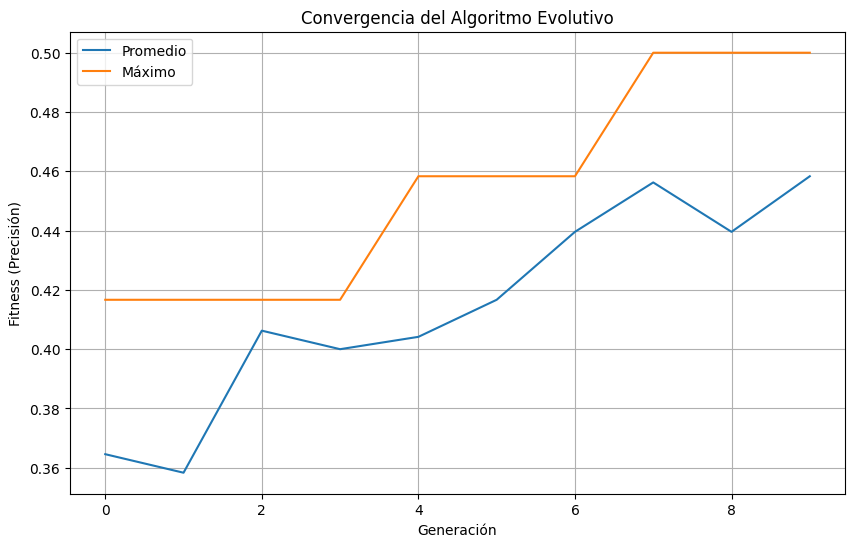

In [9]:
import matplotlib.pyplot as plt

gen = log.select("gen")
avg = log.select("avg")
max_ = log.select("max")

plt.figure(figsize=(10, 6))
plt.plot(gen, avg, label="Promedio")
plt.plot(gen, max_, label="Máximo")
plt.xlabel("Generación")
plt.ylabel("Fitness (Precisión)")
plt.title("Convergencia del Algoritmo Evolutivo")
plt.legend()
plt.grid()
plt.show()